setup

In [33]:
from FireSimulator import *

import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import sys
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


function to visualize forest

In [2]:
def visualize_forest(axis_handle, data):
    r, c = data.shape
    for i in range(r):
        for j in range(c):
            x = col_to_x(j)
            y = row_to_y(r,i)
            
            rect = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6)
            
            if data[i,j] == 0:
                rect.set_color('g')
            elif data[i,j] == 1:
                rect.set_color('r')
            elif data[i,j] == 2:
                rect.set_color('k')
                
            axis_handle.add_patch(rect)
    
    return axis_handle

parameters

In [3]:
grid_size = 25
dp = 0
alpha = 0.2763
beta = np.exp(-0.1)

nn = [(-1,0),(1,0),(0,-1),(0,1)]

neighbors = {}
for i in range(grid_size):
    for j in range(grid_size):
        neighbors[(i,j)] = []
        
        for (di,dj) in nn:
            ii = i + di
            jj = j + dj
            if ii>=0 and ii<grid_size and jj>=0 and jj<grid_size:
                neighbors[(i,j)].append((ii,jj))

In [4]:
def dynamics(xi_tm1, fi_tm1, xi_t):
    if xi_tm1 == 0:
        if xi_t == 0:
            return alpha**fi_tm1
        elif xi_t == 1:
            return 1-alpha**fi_tm1
        elif xi_t == 2:
            return 0
        
    elif xi_tm1 == 1:
        if xi_t == 0:
            return 0
        elif xi_t == 1:
            return beta
        elif xi_t == 2:
            return 1-beta
        
    elif xi_tm1 == 2:
        if xi_t == 0:
            return 0
        elif xi_t == 1:
            return 0
        elif xi_t == 2:
            return 1

first case: measurement model $p(y^{t}_{t} ~|~ x^{t}_{i})$

In [5]:
def measurement(xi_t, yi_t):
    if xi_t != yi_t:
        return 0.05
    elif xi_t == yi_t:
        return 0.9

In [57]:
def variational_method(prior, neighbors, grid_size, meas_data, Kmax=1, C=10):
    post = np.zeros_like(prior)
    post[:,:,0] = 0.34
    post[:,:,1] = 0.33
    post[:,:,2] = 0.33
    
    prior_simple = np.zeros((grid_size,grid_size,2))
    prior_simple[:,:,1] = prior[:,:,1]
    prior_simple[:,:,0] = 1 - prior_simple[:,:,1]
    
    node_data = {}
    for i in range(grid_size):
        for j in range(grid_size):
            node_data[(i,j)] = {}
            
            node_data[(i,j)]['post_simple'] = [0,0,0,0,0]
            node_data[(i,j)]['post_next'] = [0,0,0]
            
            node_data[(i,j)]['msg'] = {}
            node_data[(i,j)]['msg_simple'] = {}
            node_data[(i,j)]['msg_next'] = {}
            
            node_data[(i,j)]['prior'] = [0,0,0,0,0]
            
            num_neighbors = len(neighbors[(i,j)])
            for l in range(2**num_neighbors):
                xj = np.base_repr(l, base=2).zfill(num_neighbors)

                f = xj.count('1')

                p = 1
                for m in range(num_neighbors):
                    curr_nghbr = neighbors[(i,j)][m]
                    p *= prior_simple[curr_nghbr[0],curr_nghbr[1],int(xj[m])]
                    
                node_data[(i,j)]['prior'][f] += p
                
            #num_neighbors = len(neighbors[(i,j)])
            #for k in range(5):
            #    p_sum = 0
            #    for l in range(2**num_neighbors):
            #        xj = np.base_repr(l, base=2).zfill(num_neighbors)
            #        
            #        if xj.count('1') != k:
            #            continue
            #            
            #        p = 1
            #        for m in range(num_neighbors):
            #            curr_nghbr = neighbors[(i,j)][m]
            #            p *= prior_simple[curr_nghbr[0],curr_nghbr[1],int(xj[m])]
            #        p_sum += p
            #    
            #    node_data[(i,j)]['prior'].append(p_sum)
    
    for iteration in range(Kmax):
        
        if iteration > 0:
            post_simple = np.zeros_like(prior_simple)
            post_simple[:,:,1] = post[:,:,1]
            post_simple[:,:,0] = 1 - post_simple[:,:,1]
        
        for i in range(grid_size):
            for j in range(grid_size):

                if iteration == 0:
        
                    for xi_tm1 in range(3):
                        for xi_t in range(3):
                            value = 0
                            for fi_tm1 in range(5):
                                value += dynamics(xi_tm1, fi_tm1, xi_t)*node_data[(i,j)]['prior'][fi_tm1]
                            node_data[(i,j)]['msg_next'][(xi_tm1,xi_t)] = value
                    
                    for xi_t in range(3):
                        value = 0
                        for xi_tm1 in range(3):
                            value += prior[i,j,xi_tm1]*node_data[(i,j)]['msg_next'][(xi_tm1,xi_t)]
                        
                        #if value <= 1e-4:
                            #value = np.log(measurement(xi_t, meas_data[i,j])) - 10000
                        #else:
                            #value = np.log(measurement(xi_t, meas_data[i,j])) + np.log(value)
                            
                        value = C*measurement(xi_t, meas_data[i,j]) + C*value #-C
                        node_data[(i,j)]['post_next'][xi_t] = np.exp(value)
                        
                    node_data[(i,j)]['post_next'] /= sum(node_data[(i,j)]['post_next']) 
                    
                else:
                    
                    num_neighbors = len(neighbors[(i,j)])
                    for l in range(2**num_neighbors):
                        xj = np.base_repr(l, base=2).zfill(num_neighbors)

                        f = xj.count('1')

                        p = 1
                        for m in range(num_neighbors):
                            curr_nghbr = neighbors[(i,j)][m]
                            p *= prior_simple[curr_nghbr[0],curr_nghbr[1],int(xj[m])]

                        node_data[(i,j)]['post_simple'][f] += p
                    
                    #for k in range(5):
                    #    p_sum = 0
                    #    for l in range(2**num_neighbors):
                    #        xj = np.base_repr(l, base=2).zfill(num_neighbors)
                    #
                    #        if xj.count('1') != k:
                    #            continue
                    #
                    #        p = 1
                    #        for m in range(num_neighbors):
                    #            curr_nghbr = neighbors[(i,j)][m]
                    #            p *= post_simple[curr_nghbr[0],curr_nghbr[1],int(xj[m])]
                    #        p_sum += p
                    #
                    #    node_data[(i,j)]['post_simple'].append(p_sum)
                        
                        
                    for l1 in range(3**num_neighbors):
                        for l2 in range(3**num_neighbors):
                            
                            xj_tm1 = np.base_repr(l1, base=3).zfill(num_neighbors)
                            xj_t = np.base_repr(l2, base=3).zfill(num_neighbors)
                            
                            fi_tm1 = xj_tm1.count('1')
                            fi_t = xj_t.count('1')
                            
                            node_data[(i,j)]['msg_simple'].setdefault((fi_tm1,fi_t), 0)
                            
                            m_value = 1
                            for m in range(num_neighbors):
                                curr_nghbr = neighbors[(i,j)][m]
                                m_value *= node_data[(curr_nghbr[0],curr_nghbr[1])]['msg'][(int(xj_tm1[m]),int(xj_t[m]))]
                            
                            node_data[(i,j)]['msg_simple'][(fi_tm1,fi_t)] += m_value
                        
                    
                    #for fi_tm1 in range(5):
                    #    for fi_t in range(5):
                    #        m_sum = 0
                    #        for l1 in range(2**num_neighbors):
                    #            for l2 in range(2**num_neighbors):
                    #                
                    #                xj_tm1 = np.base_repr(l1, base=2).zfill(num_neighbors)
                    #                xj_t = np.base_repr(l2, base=2).zfill(num_neighbors)
                    #                
                    #                if xj_tm1.count('1') != fi_tm1 and xj_t.count('1') != fi_t:
                    #                    continue
                    #                    
                    #                m_value = 1
                    #                for m in range(num_neighbors):
                    #                    curr_nghbr = neighbors[(i,j)][m]
                    #                    
                    #                    if int(xj_tm1[m]) == 0 and int(xj_t[m]) == 0:
                    #                        m_value *= node_data[(curr_nghbr[0],curr_nghbr[1])]['msg'][(0,0)] + \
                    #                                   node_data[(curr_nghbr[0],curr_nghbr[1])]['msg'][(0,2)] + \
                    #                                   node_data[(curr_nghbr[0],curr_nghbr[1])]['msg'][(2,0)] + \
                    #                                   node_data[(curr_nghbr[0],curr_nghbr[1])]['msg'][(2,2)]
                    #                    elif int(xj_tm1[m]) == 0 and int(xj_t[m]) == 1:
                    #                        m_value *= node_data[(curr_nghbr[0],curr_nghbr[1])]['msg'][(0,1)] + \
                    #                                   node_data[(curr_nghbr[0],curr_nghbr[1])]['msg'][(2,1)]
                    #                    elif int(xj_tm1[m]) == 1 and int(xj_t[m]) == 0:
                    #                        m_value *= node_data[(curr_nghbr[0],curr_nghbr[1])]['msg'][(1,0)] + \
                    #                                   node_data[(curr_nghbr[0],curr_nghbr[1])]['msg'][(1,2)]
                    #                    elif int(xj_tm1[m]) == 1 and int(xj_t[m]) == 1:
                    #                        m_value *= node_data[(curr_nghbr[0],curr_nghbr[1])]['msg'][(1,1)]
                    #                    
                    #                    
                    #                m_sum += m_value
                    #        
                    #        node_data[(i,j)]['msg_simple'][(fi_tm1,fi_t)] = m_sum
                    
                    for xi_tm1 in range(3):
                        for xi_t in range(3):
                            value1 = 0
                            for fi_tm1 in range(5):
                                value2 = 0
                                for fi_t in range(5):
                                    #value2 += node_data[(i,j)]['post_simple'][fi_t]*node_data[(i,j)]['msg_simple'][(fi_tm1,fi_t)]
                                    value2 += node_data[(i,j)]['post_simple'][fi_t]*node_data[(i,j)]['msg_simple'].get((fi_tm1,fi_t), 0)
                                    
                                value1 += dynamics(xi_tm1, fi_tm1, xi_t)*node_data[(i,j)]['prior'][fi_tm1]
                                
                            node_data[(i,j)]['msg_next'][(xi_tm1,xi_t)] = value1
                                 
                    for xi_t in range(3):
                        value = 0
                        for xi_tm1 in range(3):
                            value += prior[i,j,xi_tm1]*node_data[(i,j)]['msg_next'][(xi_tm1,xi_t)]
                        
                        value = C*measurement(xi_t, meas_data[i,j]) + C*value #-C
                        node_data[(i,j)]['post_next'][xi_t] = np.exp(value)
                        
                    node_data[(i,j)]['post_next'] /= sum(node_data[(i,j)]['post_next']) 
                            
        for i in range(grid_size):
            for j in range(grid_size):
                node_data[(i,j)]['msg'] = copy.copy(node_data[(i,j)]['msg_next'])
                post[i,j,:] = copy.copy(node_data[(i,j)]['post_next'])
                
                #node_data[(i,j)]['msg_next'] = {}
                #node_data[(i,j)]['post_next'] = [0,0,0]
    
    return post

In [58]:
np.random.seed(1)

sim = FireSimulator(grid_size, alpha=alpha, beta=beta)

sim.step([], dbeta=dp)

belief = np.zeros((grid_size,grid_size,3))
idx = np.where(sim.state==0)
belief[idx[0],idx[1],:] = [1,0,0]
idx = np.where(sim.state==1)
belief[idx[0],idx[1],:] = [0,1,0]
idx = np.where(sim.state==2)
belief[idx[0],idx[1],:] = [0,0,1]

meas_data = sim.state
state_est = np.argmax(belief, axis=2) 
meas_errors = []
state_errors = []

plotting = False

if plotting:
    fig = plt.figure(figsize=(15,15))

    ax1 = fig.add_subplot(131, aspect='equal')
    ax1.set_xlim([0,grid_size+1])
    ax1.set_ylim([0,grid_size+1])
    plt.title('ground truth\nt = %d' %sim.iter)
    plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax1 = visualize_forest(ax1, sim.state)

    ax2 = fig.add_subplot(132, aspect='equal')
    ax2.set_xlim([0,grid_size+1])
    ax2.set_ylim([0,grid_size+1])
    plt.title('measurement: %d error(s)\nt = %d' %(np.sum(meas_data != sim.state),sim.iter))
    plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax2 = visualize_forest(ax2, meas_data)

    ax3 = fig.add_subplot(133, aspect='equal')
    ax3.set_xlim([0,grid_size+1])
    ax3.set_ylim([0,grid_size+1])
    plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.title('estimate: %d error(s)\nt = %d' %(np.sum(state_est != sim.state),sim.iter))
    ax3 = visualize_forest(ax3, state_est)
    
    rows, cols = np.where(state_est != sim.state)
    for i, j in zip(rows, cols):
        x = col_to_x(j)
        y = row_to_y(grid_size, i)
        plt.plot(x, y, marker='o', color='b')

tic = time.clock()
# for _ in range(25):
while not sim.end:
    
    sim.step([], dbeta=dp)
    
    meas_data = np.zeros_like(sim.state) + -1
    for i in range(grid_size):
        for j in range(grid_size):
            
            meas = sim.state[i,j]
            p_list = [0.05,0.05,0.05]
            p_list[meas] += 0.85
            meas_data[i,j] = np.random.choice([0,1,2], p=p_list)
    
    belief = variational_method(belief, neighbors, grid_size, meas_data, Kmax=2)
    state_est = np.argmax(belief, axis=2)
    
    num_errors = np.sum(state_est != sim.state)
    state_errors.append(num_errors)
    meas_errors.append(np.sum(meas_data != sim.state))
    #print('iteration %03d: %d errors' %(sim.iter,num_errors))
    
    if plotting:
        fig = plt.figure(figsize=(15,15))

        ax1 = fig.add_subplot(131, aspect='equal')
        ax1.set_xlim([0,grid_size+1])
        ax1.set_ylim([0,grid_size+1])
        plt.title('ground truth\nt = %d' %sim.iter)
        plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        ax1 = visualize_forest(ax1, sim.state)

        ax2 = fig.add_subplot(132, aspect='equal')
        ax2.set_xlim([0,grid_size+1])
        ax2.set_ylim([0,grid_size+1])
        plt.title('measurement: %d error(s)\nt = %d' %(np.sum(meas_data != sim.state),sim.iter))
        plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        ax2 = visualize_forest(ax2, meas_data)

        ax3 = fig.add_subplot(133, aspect='equal')
        ax3.set_xlim([0,grid_size+1])
        ax3.set_ylim([0,grid_size+1])
        plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        plt.title('estimate: %d error(s)\nt = %d' %(np.sum(state_est != sim.state),sim.iter))
        ax3 = visualize_forest(ax3, state_est)

        rows, cols = np.where(state_est != sim.state)
        for i, j in zip(rows, cols):
            x = col_to_x(j)
            y = row_to_y(grid_size, i)
            plt.plot(x, y, marker='o', color='b')
    
toc = time.clock()
print('median number of errors: %0.2f' %(np.median(state_errors)))
print('median percent error: %0.3f' %(np.median(state_errors)*100/grid_size**2))
print('%0.2fs = %0.2fm elapsed' % (toc-tic,(toc-tic)/60))

median number of errors: 14.00
median percent error: 2.240
1941.24s = 32.35m elapsed


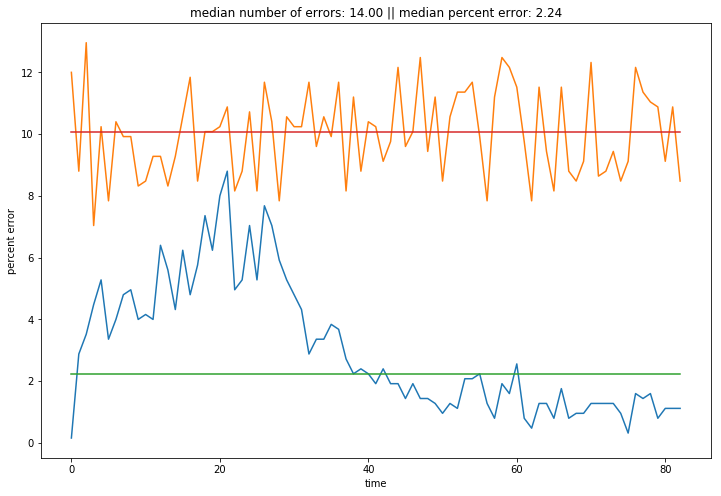

In [60]:
plot_state_errors = [100*e/grid_size**2 for e in state_errors]
plot_meas_errors = [100*e/grid_size**2 for e in meas_errors]

plt.figure(figsize=(12,8))
plt.plot(plot_state_errors)
plt.plot(plot_meas_errors)
plt.plot(range(len(plot_state_errors)),np.median(plot_state_errors)*np.ones(len(plot_state_errors)))
plt.plot(range(len(plot_meas_errors)),np.median(plot_meas_errors)*np.ones(len(plot_meas_errors)))

plt.title('median number of errors: %0.2f || median percent error: %0.2f' %(np.median(state_errors),np.median(state_errors)*100/grid_size**2))
plt.ylabel('percent error')
plt.xlabel('time')